**# RESNET50 + D0**

In [ ]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
import torchvision
import torch.nn.functional as F
from torch import optim
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

**# Dataset Processing**

In [ ]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

data_path = '/content/drive/MyDrive/AI/Datasets/D0' 

image_paths = [] 
classes = [] 

for data_path in glob.glob(data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    image_paths.append(glob.glob(data_path + '/*'))
    
image_paths = list(flatten(image_paths))
random.shuffle(image_paths)

train_image_paths, valid_test_image_paths = image_paths[:int(0.7*len(image_paths))], image_paths[int(0.7*len(image_paths)):]
valid_image_paths, test_image_paths = valid_test_image_paths[:int(0.7*len(valid_test_image_paths))], valid_test_image_paths[int(0.7*len(valid_test_image_paths)):]

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

class D0Dataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label
    
train_dataset = D0Dataset(train_image_paths,train_transforms)
valid_dataset = D0Dataset(valid_image_paths,test_transforms)
test_dataset = D0Dataset(test_image_paths,test_transforms)


train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

print(next(iter(train_loader))[0].shape)
print(next(iter(train_loader))[1].shape)

Train size: 3155
Valid size: 947
Test size: 406
torch.Size([64, 3, 224, 224])
torch.Size([64])


# Visualize datasets

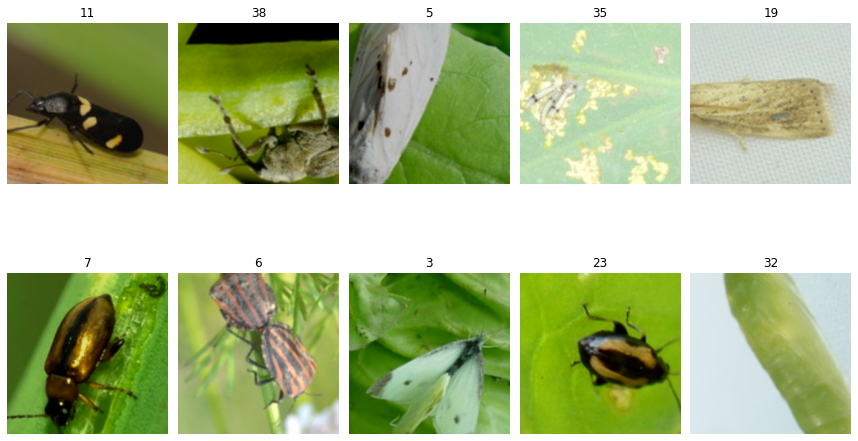

In [ ]:
%matplotlib inline

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

# **Define Model, Loss Function, Optimizer**

In [ ]:
net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
net.fc = nn.Sequential(
    nn.Linear(net.fc.in_features, 40)
)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **Training and save Model**

In [ ]:
import time
for epoch in range(40):
    running_loss = 0.0
    t0 = time.time()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss}, time: {time.time() - t0}')
        running_loss = 0.0
print('Finished Training')
PATH = '/content/drive/MyDrive/AI/ResNet_D0'
torch.save(net.state_dict(), PATH)

[1,     1] loss: 1.3333526849746704, time: 0.4791562557220459
[1,     2] loss: 1.0548887252807617, time: 0.9689440727233887
[1,     3] loss: 1.0304322242736816, time: 1.458390712738037
[1,     4] loss: 1.29000985622406, time: 1.9496171474456787
[1,     5] loss: 1.4743492603302002, time: 2.4216883182525635
[1,     6] loss: 0.9563987851142883, time: 2.887585401535034
[1,     7] loss: 1.4297435283660889, time: 3.3819501399993896
[1,     8] loss: 1.2061729431152344, time: 3.8706653118133545
[1,     9] loss: 1.227554440498352, time: 4.3453943729400635
[1,    10] loss: 1.1353768110275269, time: 4.837837219238281
[1,    11] loss: 1.1426265239715576, time: 5.315436124801636
[1,    12] loss: 1.3060187101364136, time: 5.7959208488464355
[1,    13] loss: 1.1729636192321777, time: 6.28424596786499
[1,    14] loss: 1.0823255777359009, time: 6.76872706413269
[1,    15] loss: 1.3402096033096313, time: 7.254272937774658
[1,    16] loss: 1.2710846662521362, time: 7.725383758544922
[1,    17] loss: 1.24

# **Load Model and Testing**

In [ ]:
PATH = '/content/drive/MyDrive/AI/ResNet50_D0'
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 40)
)
model.load_state_dict(torch.load(PATH))
model = model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the total test images: {100 * correct // total} %')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy of the network on the total test images: 88 %
